# Sensitivity Analysis: using combined distance

In order to systematically probe a parameter's sensitivity, its partial derivative wrt the distance is calculated, and its range at 2.5, 5, 10 and 25% (for example) of the final parameter are averaged to get a final metric

 ## First, let's generate the data, just having k1 as a parameter:

In [99]:
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import numpy as np 
import peakutils
import numpy.fft as fft
import matplotlib.pyplot as plt


#Distance function
def euclidean_distance_multiple_trajectories(observed_trajectories, simulated_trajectories):
    num_trajectories = len(observed_trajectories)
    total_distance = 0.0

    for i in range(num_trajectories):
        observed_data = observed_trajectories[i]
        simulated_data = simulated_trajectories[i]

        # Calculate the Euclidean distance between observed and simulated data
        euclidean_distance = np.linalg.norm(observed_data - simulated_data)

        # Accumulate the distances
        total_distance += euclidean_distance

    # Average the distances over all trajectories
    average_distance = total_distance / num_trajectories

    return average_distance
# Only what we need
def getDif(indexes, arrayData):	
    arrLen = len(indexes)
    sum = 0
    for i, ind in enumerate(indexes):
        if i == arrLen - 1:
            break
        sum += arrayData[ind] - arrayData[indexes[i + 1]]
        
    #add last peak - same as substracting it from zero 
    sum += arrayData[indexes[-1:]]  
    return sum   
    
#gets standard deviation 
def getSTD(indexes, arrayData, window):
    numPeaks = len(indexes)
    arrLen = len(arrayData)
    sum = 0
    for ind in indexes:
        minInd = max(0, ind - window)
        maxInd = min(arrLen, ind + window)
        sum += np.std(arrayData[minInd:maxInd])  
        
    sum = sum/numPeaks 	#The 1/P factor
    return sum
    
def getFrequencies(y):
    res = abs(fft.rfft(y))  #Real FT
    #normalize the amplitudes 
    #res = res/math.ceil(1/2) #Normalise with a factor of 1/2
    return res

def costTwo(Y): #Yes
    p1 = Y[:,1]  #Get the first column
    fftData = getFrequencies(p1)    #Get frequencies of FFT of the first column  
    fftData = np.array(fftData) 
    #find peaks using very low threshold and minimum distance
    indexes = peakutils.indexes(fftData, thres=0.02/max(fftData), min_dist=1)  #Just find peaks
    #in case of no oscillations return 0 
    if len(indexes) == 0:     
        return 0
    #if amplitude is greater than 400nM
    #global amp
    #amp = np.max(fftData[indexes])
    #if amp > 400: #If bigger than 400, then cost is 0, not viable
      #  return 0, 
    # fitSamples = fftData[indexes]  			
    std = getSTD(indexes, fftData, 1)  #get sd of peaks at a window of 1 (previous peak)
    diff = getDif(indexes, fftData)  #Get differences in peaks
    cost = std + diff 
    return int(cost)

def combined_distance(observed_trajectory, simulated_trajectory):
    euclidean_distance = euclidean_distance_multiple_trajectories(observed_trajectory, simulated_trajectory)
    penalising_factor = np.abs(np.abs(costTwo(simulated_trajectory)) - 200)
    if costTwo(simulated_trajectory) >= 200:
        return euclidean_distance
    else:
        if penalising_factor < 1:
            penalising_factor = 1
        return euclidean_distance * penalising_factor

In [100]:
def model(variables, t, params):

    m1, p1, m2, p2, m3, p3 = variables
    k1 = params
    k2 = 246.96291990024542
    k3 = 246.96291990024542
    a1 = 24.78485282457379
    a2 = 24.78485282457379
    a3 = 24.78485282457379
    g1 = 0.024884149937163258
    g2 = 0.024884149937163258
    g3 = 0.024884149937163258
    n1 = 5
    n2 = 5
    n3 = 5
    b1 = 33.82307682700831
    b2 = 33.82307682700831
    b3 = 33.82307682700831
    dm1 = 1.143402097500176
    dm2 = 1.143402097500176
    dm3 = 1.143402097500176
    dp1 = 0.7833664565550977
    dp2 = 0.7833664565550977
    dp3 = 0.7833664565550977

    dm1dt = -dm1 * m1 + (a1 / (1 + ((1/k1) * p2) ** n1)) + g1
    dp1dt = (b1 * m1) - (dp1 * p1)
    dm2dt = -dm2 * m2 + (a2 / (1 + ((1/k2) * p3) ** n2)) + g2
    dp2dt = (b2 * m2) - (dp2 * p2)
    dm3dt = -dm3 * m3 + (a3 / (1 + ((1/k3) * p1) ** n3)) + g3
    dp3dt = (b3 * m3) - (dp3 * p3)
    
    return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

true_params = np.array([
    246.96291990024542  # first set of odes
])

def solve_ode(params, t):
    initial_conditions = np.array([0, 1, 0, 3, 0, 2])
    solution = odeint(model, initial_conditions, t, args=(params,))
    return solution

num_timesteps = 1000  # Number of time steps for simulation
t = np.linspace(0, 100, num_timesteps)
true_data = solve_ode(true_params, t)
true_data

array([[  0.        ,   1.        ,   0.        ,   3.        ,
          0.        ,   2.        ],
       [  2.34660602,   4.86804399,   2.34660602,   6.71720517,
          2.34660602,   5.79262458],
       [  4.43943119,  15.65925938,   4.43943145,  17.36895814,
          4.43943165,  16.51410904],
       ...,
       [  0.944322  ,  34.6692896 ,   1.98221468, 357.99272038,
         21.07125846, 746.84385659],
       [  1.20635185,  35.54360348,   1.77904851, 337.10669668,
         21.13892285, 759.2464713 ],
       [  1.54252981,  37.32367539,   1.59718204, 317.17006824,
         21.19924182, 770.92168979]])

Text(0.5, 0, 'k1')

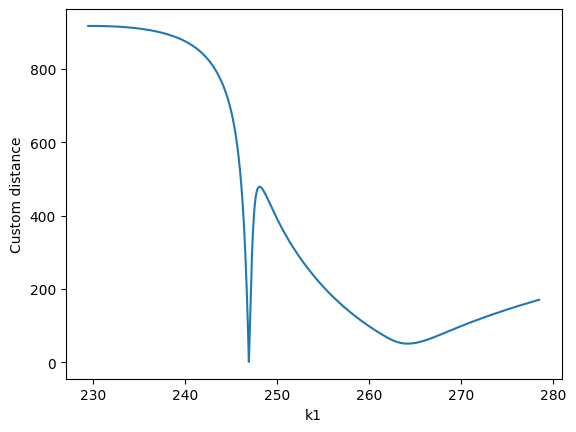

In [101]:
datapoints = 1000
k1_seq = np.linspace(229.5, 278.5, datapoints)
D_k1 = []
k1_collect = []
for i in range(np.size(k1_seq)):
    k1params = np.array([k1_seq[i]])
    k1_collect.append(k1params)
    data_k1 = solve_ode(k1params, t)
    dist = combined_distance(true_data, data_k1)
    D_k1.append(dist)

plt.plot(k1_seq, D_k1)
plt.ylabel("Custom distance")
plt.xlabel("k1")

## We now calculate the metric by obtaining the derivative of the distance wrt the parameter

In [102]:
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from scipy.integrate import odeint

def model(variables, t, params):

    m1, p1, m2, p2, m3, p3 = variables
    k1, k2, k3, a1, a2, a3, g1, g2, g3, n1, n2, n3, b1, b2, b3, dm1, dm2, dm3, dp1, dp2, dp3 = params

    dm1dt = -dm1 * m1 + (a1 / (1 + ((1/k1) * p2) ** n1)) + g1
    dp1dt = (b1 * m1) - (dp1 * p1)
    dm2dt = -dm2 * m2 + (a2 / (1 + ((1/k2) * p3) ** n2)) + g2
    dp2dt = (b2 * m2) - (dp2 * p2)
    dm3dt = -dm3 * m3 + (a3 / (1 + ((1/k3) * p1) ** n3)) + g3
    dp3dt = (b3 * m3) - (dp3 * p3)
    
    return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

true_params = np.array([
    246.96291990024542, 246.96291990024542, 246.96291990024542,
    24.78485282457379, 24.78485282457379, 24.78485282457379,
    0.024884149937163258, 0.024884149937163258, 0.024884149937163258,
    5, 5, 5,
    33.82307682700831, 33.82307682700831, 33.82307682700831,
    1.143402097500176, 1.143402097500176, 1.143402097500176,
    0.7833664565550977, 0.7833664565550977, 0.7833664565550977
])

def solve_ode(params, t):
    initial_conditions = np.array([0, 1, 0, 3, 0, 2])
    solution = odeint(model, initial_conditions, t, args=(params,))
    return solution

num_timesteps = 1000  # Number of time steps for simulation
t = np.linspace(0, 100, num_timesteps)
true_data = solve_ode(true_params, t)
true_data

array([[  0.        ,   1.        ,   0.        ,   3.        ,
          0.        ,   2.        ],
       [  2.34660602,   4.86804399,   2.34660602,   6.71720517,
          2.34660602,   5.79262458],
       [  4.43943119,  15.65925938,   4.43943145,  17.36895814,
          4.43943165,  16.51410904],
       ...,
       [  0.944322  ,  34.6692896 ,   1.98221468, 357.99272038,
         21.07125846, 746.84385659],
       [  1.20635185,  35.54360348,   1.77904851, 337.10669668,
         21.13892285, 759.2464713 ],
       [  1.54252981,  37.32367539,   1.59718204, 317.17006824,
         21.19924182, 770.92168979]])

# Full sensitivity analysis for k

In [103]:
#To get index of the minimum D:
def min_val_ind(arr_y):
    target_value = min(arr_y)
    indices = np.where(arr_y == target_value)[0]
    
    if indices.size > 0:
        return indices

#The only thing we need to change is where the parameter is in param space! And distance function if we want!

def plots_sensitivity():
    datapoints = 1000 # How many steps in parameter space we have taken
    p_seq = np.linspace(229.5, 278.5, datapoints) #Change depending on parameter
    D_p = []
    p_collect = []
    for i in range(np.size(p_seq)):
        ########################################
        p_params = np.array([
                    p_seq[i], 246.96291990024542, 246.96291990024542,
                    24.78485282457379, 24.78485282457379, 24.78485282457379,
                    0.024884149937163258, 0.024884149937163258, 0.024884149937163258,
                    5, 5, 5,
                    33.82307682700831, 33.82307682700831, 33.82307682700831,
                    1.143402097500176, 1.143402097500176, 1.143402097500176,
                    0.7833664565550977, 0.7833664565550977, 0.7833664565550977
                    ]) #Need to change this! In this case k1
        ########################################
        p_collect.append(p_params)
        data_p = solve_ode(p_params, t)
        dist = combined_distance(true_data, data_p) #Can also change the distance function
        D_p.append(dist)

    step_size = np.array([100,500,1000]) #Steps to take right and left, the higher 
                                        #the number, the closer to the true value, here 1%, 0.1%, 0.02% of true value

    #To get indices we sample:
    indices_array = []
    for i in step_size:
        indices_array.append(np.array([datapoints//i, -datapoints//i])) #How many steps do we record?

    #To get the ks that correspond to the indices we sample, and create useful arrays:
    global min_ind
    min_ind = int(min_val_ind(D_p))
    global lowestD_p
    lowestD_p = p_seq[min_ind]
    global lowestD
    lowestD = D_p[min_ind]
    p_array = np.array([p_seq, D_p])
    grad = np.gradient(p_array) #Could also do np.diff, same result
    dDdp = grad[1][1]
    array_p_eval = []
    array_D_eval = []
    dD_array = []
    for i in indices_array:
        upperp = min_ind + i[0]
        lowerp = min_ind - i[0]
        array_p_eval.append(np.array([p_seq[int(upperp)], p_seq[int(lowerp)]])) #Save parameters
        array_D_eval.append(np.array([D_p[int(upperp)], D_p[int(lowerp)]])) #Same for distance
        dD_array.append(np.array([dDdp[int(upperp)], dDdp[int(lowerp)]])) #Same for derivative

    
    fig, axs = plt.subplots(1, 2, figsize=(12, 8))
    axs = axs.flatten()
    axs[0].plot(p_seq, D_p)
    axs[0].set_ylabel("Custom distance")
    axs[0].set_xlabel("p")
    axs[1].plot(p_seq, dDdp)
    axs[1].set_ylabel("dD/dp")
    axs[1].set_xlabel("p")

    return min_ind, p_seq, D_p, dDdp, array_p_eval, array_D_eval #It returns where it is being evaluated!

def calc_sens_metric(array_p_eval, array_D_eval):
    p_raw = []
    D_raw = []
    for i in array_p_eval:  # Get raw arrays for metric calculation
        p_raw.append(i[0])
        p_raw.append(i[1])
    for i in array_D_eval:  # Get raw arrays for metric calculation
        D_raw.append(i[0])
        D_raw.append(i[1])
    deltaD = []
    deltap = []
    for p in p_raw:
        deltap.append(np.abs(p) - np.abs(lowestD_p))
    for D in D_raw:
        deltaD.append(np.abs(D) - np.abs(lowestD))
    metric = []
    for i in range(len(deltaD)):
        metric.append(np.abs(deltaD[i]) / np.abs(deltap[i]))
    result_sense = np.log(np.mean(metric))
    return result_sense

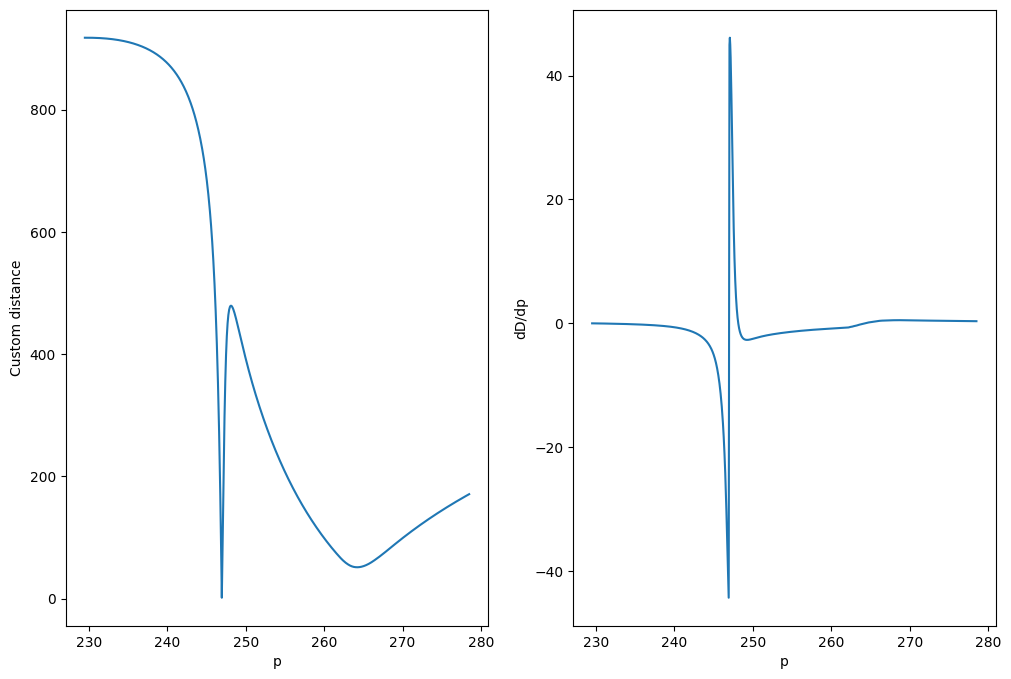

In [104]:
min_k, k_seq, D_k, dDdk, array_p_eval_k, array_D_eval_k = plots_sensitivity()

In [105]:
metric_k = calc_sens_metric(array_p_eval_k, array_D_eval_k)

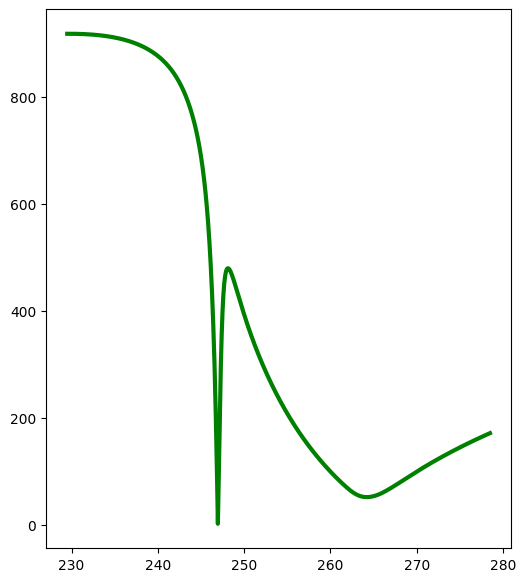

In [106]:
fig, ax = plt.subplots(figsize=(6,7))
ax.plot(k_seq, D_k, color = "green", label = "k", linewidth = 3) 

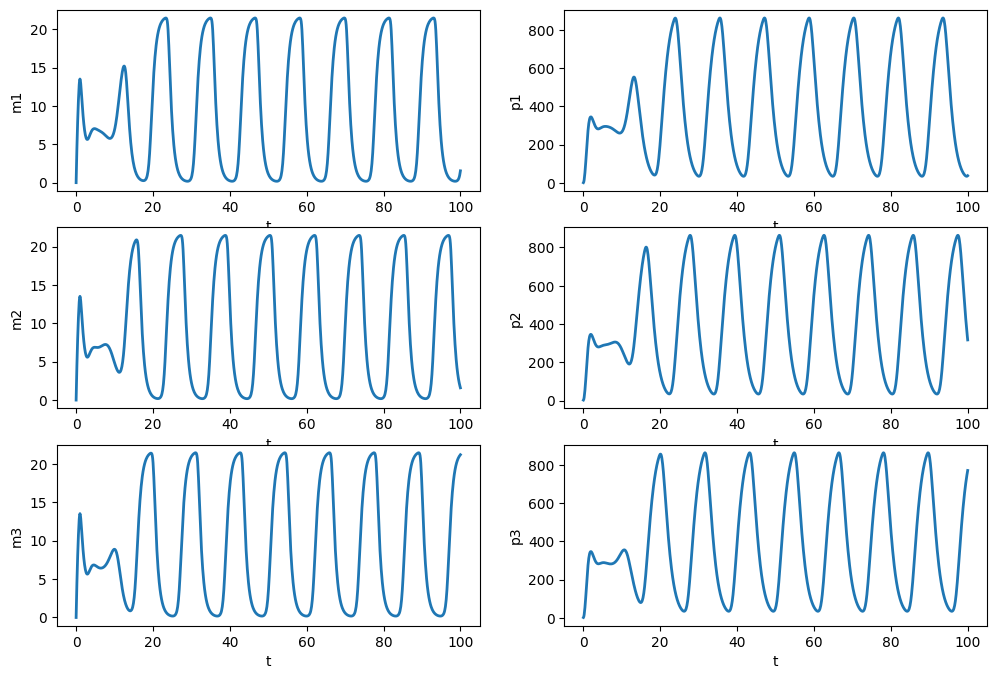

In [107]:
#Plot real trajectories for security
fig, axs = plt.subplots(3, 2, figsize=(12, 8))
axs = axs.flatten()

variable_labels = ['m1', 'p1', 'm2', 'p2', 'm3', 'p3']
for i in range(6):
    axs[i].plot(t, true_data[:, i], label='True Data', linewidth=2)
    axs[i].set_xlabel('t')
    axs[i].set_ylabel(variable_labels[i])

## Do with a

In [108]:
#The only thing we need to change is where the parameter is in param space! And distance function if we want!

def plots_sensitivity():
    datapoints = 1000 # How many steps in parameter space we have taken
    p_seq = np.linspace(22.3, 27.26, datapoints) #Change depending on parameter, 10%
    D_p = []
    p_collect = []
    for i in range(np.size(p_seq)):
        ########################################
        p_params = np.array([
                    246.96291990024542, 246.96291990024542, 246.96291990024542,
                    p_seq[i], 24.78485282457379, 24.78485282457379,
                    0.024884149937163258, 0.024884149937163258, 0.024884149937163258,
                    5, 5, 5,
                    33.82307682700831, 33.82307682700831, 33.82307682700831,
                    1.143402097500176, 1.143402097500176, 1.143402097500176,
                    0.7833664565550977, 0.7833664565550977, 0.7833664565550977
                    ]) #Need to change this! In this case k1
        ########################################
        p_collect.append(p_params)
        data_p = solve_ode(p_params, t)
        dist = combined_distance(true_data, data_p) #Can also change the distance function
        D_p.append(dist)

    step_size = np.array([100,500,1000]) #Steps to take right and left, the higher 
                                        #the number, the closer to the true value, here 1%, 0.1%, 0.02% of true value

    #To get indices we sample:
    indices_array = []
    for i in step_size:
        indices_array.append(np.array([datapoints//i, -datapoints//i])) #How many steps do we record?

    #To get the ks that correspond to the indices we sample, and create useful arrays:
    global min_ind
    min_ind = int(min_val_ind(D_p))
    global lowestD_p
    lowestD_p = p_seq[min_ind]
    global lowestD
    lowestD = D_p[min_ind]
    p_array = np.array([p_seq, D_p])
    grad = np.gradient(p_array) #Could also do np.diff, same result
    dDdp = grad[1][1]
    array_p_eval = []
    array_D_eval = []
    dD_array = []
    for i in indices_array:
        upperp = min_ind + i[0]
        lowerp = min_ind - i[0]
        array_p_eval.append(np.array([p_seq[int(upperp)], p_seq[int(lowerp)]])) #Save parameters
        array_D_eval.append(np.array([D_p[int(upperp)], D_p[int(lowerp)]])) #Same for distance
        dD_array.append(np.array([dDdp[int(upperp)], dDdp[int(lowerp)]])) #Same for derivative

    
    fig, axs = plt.subplots(1, 2, figsize=(12, 8))
    axs = axs.flatten()
    axs[0].plot(p_seq, D_p)
    axs[0].set_ylabel("Custom distance")
    axs[0].set_xlabel("p")
    axs[1].plot(p_seq, dDdp)
    axs[1].set_ylabel("dD/dp")
    axs[1].set_xlabel("p")

    return min_ind, p_seq, D_p, dDdp, array_p_eval, array_D_eval #It returns where it is being evaluated!

def calc_sens_metric(array_p_eval, array_D_eval):
    p_raw = []
    D_raw = []
    for i in array_p_eval:  # Get raw arrays for metric calculation
        p_raw.append(i[0])
        p_raw.append(i[1])
    for i in array_D_eval:  # Get raw arrays for metric calculation
        D_raw.append(i[0])
        D_raw.append(i[1])
    deltaD = []
    deltap = []
    for p in p_raw:
        deltap.append(np.abs(p) - np.abs(lowestD_p))
    for D in D_raw:
        deltaD.append(np.abs(D) - np.abs(lowestD))
    metric = []
    for i in range(len(deltaD)):
        metric.append(np.abs(deltaD[i]) / np.abs(deltap[i]))
    result_sense = np.log(np.mean(metric))
    return result_sense

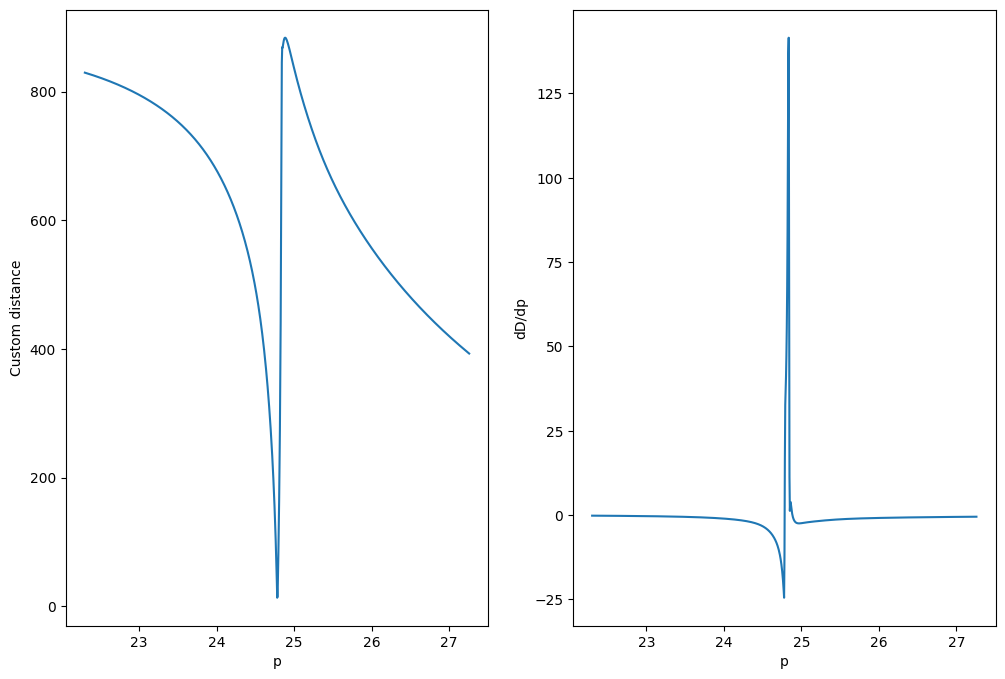

In [109]:
min_a, a_seq, D_a, dDda, array_p_eval_a, array_D_eval_a = plots_sensitivity()

In [110]:
a_metric = calc_sens_metric(array_p_eval_a, array_D_eval_a)

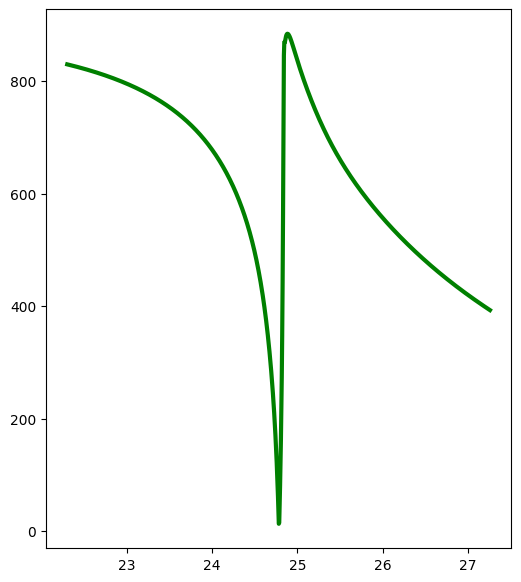

In [111]:
fig, ax = plt.subplots(figsize=(6,7))
ax.plot(a_seq, D_a, color = "green", label = "a", linewidth = 3) 

# Now do with g: EXCEPTION, we have widened the gap because the scale is very small...

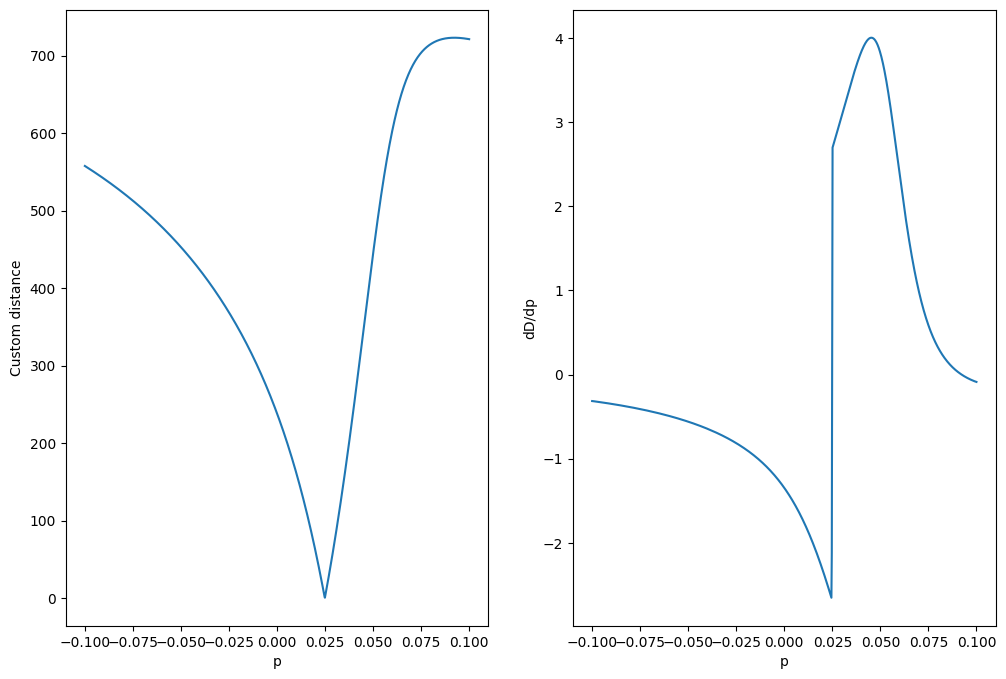

In [112]:
def plots_sensitivity():
    datapoints = 1000 # How many steps in parameter space we have taken
    p_seq = np.linspace(-0.1, 0.1, datapoints) #Change depending on parameter, 10%
    D_p = []
    p_collect = []
    for i in range(np.size(p_seq)):
        ########################################
        p_params = np.array([
                    246.96291990024542, 246.96291990024542, 246.96291990024542,
                    24.78485282457379, 24.78485282457379, 24.78485282457379,
                    p_seq[i], 0.024884149937163258, 0.024884149937163258,
                    5, 5, 5,
                    33.82307682700831, 33.82307682700831, 33.82307682700831,
                    1.143402097500176, 1.143402097500176, 1.143402097500176,
                    0.7833664565550977, 0.7833664565550977, 0.7833664565550977
                    ]) #Need to change this! In this case k1
        ########################################
        p_collect.append(p_params)
        data_p = solve_ode(p_params, t)
        dist = combined_distance(true_data, data_p) #Can also change the distance function
        D_p.append(dist)

    step_size = np.array([100,500,1000]) #Steps to take right and left, the higher 
                                        #the number, the closer to the true value, here 1%, 0.1%, 0.02% of true value

    #To get indices we sample:
    indices_array = []
    for i in step_size:
        indices_array.append(np.array([datapoints//i, -datapoints//i])) #How many steps do we record?

    #To get the ks that correspond to the indices we sample, and create useful arrays:
    global min_ind
    min_ind = int(min_val_ind(D_p))
    global lowestD_p
    lowestD_p = p_seq[min_ind]
    global lowestD
    lowestD = D_p[min_ind]
    p_array = np.array([p_seq, D_p])
    grad = np.gradient(p_array) #Could also do np.diff, same result
    dDdp = grad[1][1]
    array_p_eval = []
    array_D_eval = []
    dD_array = []
    for i in indices_array:
        upperp = min_ind + i[0]
        lowerp = min_ind - i[0]
        array_p_eval.append(np.array([p_seq[int(upperp)], p_seq[int(lowerp)]])) #Save parameters
        array_D_eval.append(np.array([D_p[int(upperp)], D_p[int(lowerp)]])) #Same for distance
        dD_array.append(np.array([dDdp[int(upperp)], dDdp[int(lowerp)]])) #Same for derivative

    
    fig, axs = plt.subplots(1, 2, figsize=(12, 8))
    axs = axs.flatten()
    axs[0].plot(p_seq, D_p)
    axs[0].set_ylabel("Custom distance")
    axs[0].set_xlabel("p")
    axs[1].plot(p_seq, dDdp)
    axs[1].set_ylabel("dD/dp")
    axs[1].set_xlabel("p")

    return min_ind, p_seq, D_p, dDdp, array_p_eval, array_D_eval

min_g, g_seq, D_g, dDdg, array_p_eval_g, array_D_eval_g = plots_sensitivity()

In [113]:
g_metric = calc_sens_metric(array_p_eval_g, array_D_eval_g)

Tricky because the scale is very small...

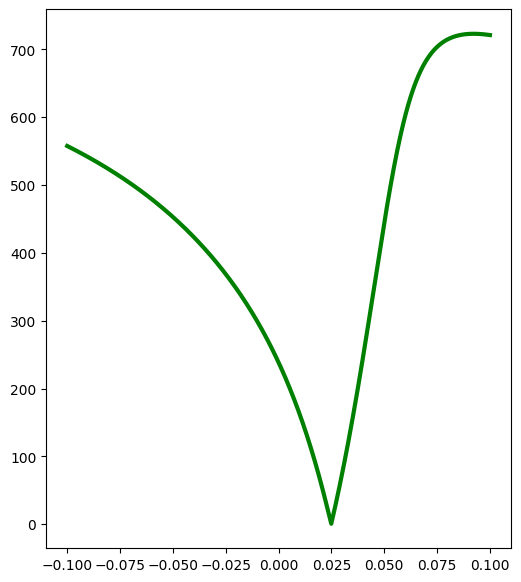

In [114]:
fig, ax = plt.subplots(figsize=(6,7))
ax.plot(g_seq, D_g, color = "green", label = "g", linewidth = 3) 

# Now do n

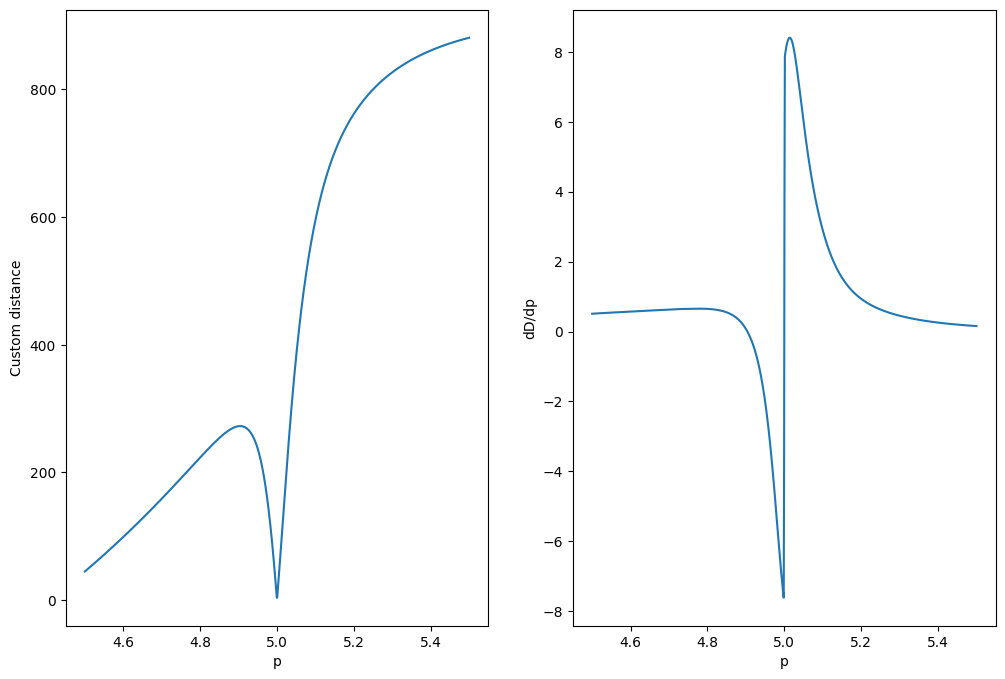

In [115]:
#The only thing we need to change is where the parameter is in param space! And distance function if we want!

def plots_sensitivity():
    datapoints = 1000 # How many steps in parameter space we have taken
    p_seq = np.linspace(4.5, 5.5, datapoints) #Change depending on parameter, 10%
    D_p = []
    p_collect = []
    for i in range(np.size(p_seq)):
        ########################################
        p_params = np.array([
                    246.96291990024542, 246.96291990024542, 246.96291990024542,
                    24.78485282457379, 24.78485282457379, 24.78485282457379,
                    0.024884149937163258, 0.024884149937163258, 0.024884149937163258,
                    p_seq[i], 5, 5,
                    33.82307682700831, 33.82307682700831, 33.82307682700831,
                    1.143402097500176, 1.143402097500176, 1.143402097500176,
                    0.7833664565550977, 0.7833664565550977, 0.7833664565550977
                    ]) #Need to change this! In this case k1
        ########################################
        p_collect.append(p_params)
        data_p = solve_ode(p_params, t)
        dist = combined_distance(true_data, data_p) #Can also change the distance function
        D_p.append(dist)

    step_size = np.array([100,500,1000]) #Steps to take right and left, the higher 
                                        #the number, the closer to the true value, here 1%, 0.1%, 0.02% of true value

    #To get indices we sample:
    indices_array = []
    for i in step_size:
        indices_array.append(np.array([datapoints//i, -datapoints//i])) #How many steps do we record?

    #To get the ks that correspond to the indices we sample, and create useful arrays:
    global min_ind
    min_ind = int(min_val_ind(D_p))
    global lowestD_p
    lowestD_p = p_seq[min_ind]
    global lowestD
    lowestD = D_p[min_ind]
    p_array = np.array([p_seq, D_p])
    grad = np.gradient(p_array) #Could also do np.diff, same result
    dDdp = grad[1][1]
    array_p_eval = []
    array_D_eval = []
    dD_array = []
    for i in indices_array:
        upperp = min_ind + i[0]
        lowerp = min_ind - i[0]
        array_p_eval.append(np.array([p_seq[int(upperp)], p_seq[int(lowerp)]])) #Save parameters
        array_D_eval.append(np.array([D_p[int(upperp)], D_p[int(lowerp)]])) #Same for distance
        dD_array.append(np.array([dDdp[int(upperp)], dDdp[int(lowerp)]])) #Same for derivative

    
    fig, axs = plt.subplots(1, 2, figsize=(12, 8))
    axs = axs.flatten()
    axs[0].plot(p_seq, D_p)
    axs[0].set_ylabel("Custom distance")
    axs[0].set_xlabel("p")
    axs[1].plot(p_seq, dDdp)
    axs[1].set_ylabel("dD/dp")
    axs[1].set_xlabel("p")

    return min_ind, p_seq, D_p, dDdp, array_p_eval, array_D_eval #It returns where it is being evaluated!

def calc_sens_metric(array_p_eval, array_D_eval):
    p_raw = []
    D_raw = []
    for i in array_p_eval:  # Get raw arrays for metric calculation
        p_raw.append(i[0])
        p_raw.append(i[1])
    for i in array_D_eval:  # Get raw arrays for metric calculation
        D_raw.append(i[0])
        D_raw.append(i[1])
    deltaD = []
    deltap = []
    for p in p_raw:
        deltap.append(np.abs(p) - np.abs(lowestD_p))
    for D in D_raw:
        deltaD.append(np.abs(D) - np.abs(lowestD))
    metric = []
    for i in range(len(deltaD)):
        metric.append(np.abs(deltaD[i]) / np.abs(deltap[i]))
    result_sense = np.log(np.mean(metric))
    return result_sense

min_n, n_seq, D_n, dDdn, array_p_eval_n, array_D_eval_n = plots_sensitivity()

In [116]:
n_metric = calc_sens_metric(array_p_eval_n, array_D_eval_n)

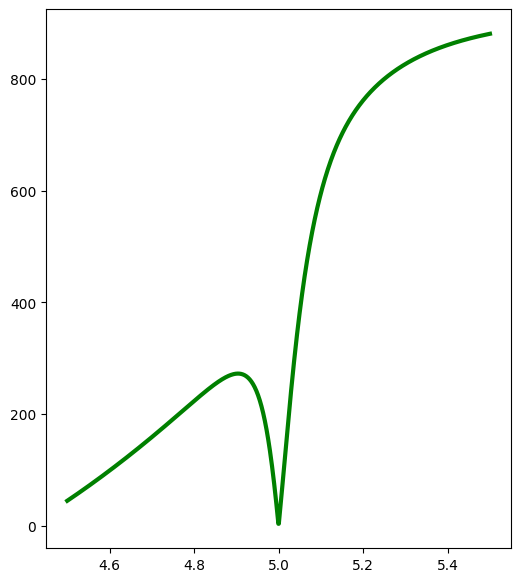

In [117]:
fig, ax = plt.subplots(figsize=(6,7))
ax.plot(n_seq, D_n, color = "green", label = "n", linewidth = 3) 

# Now try with b

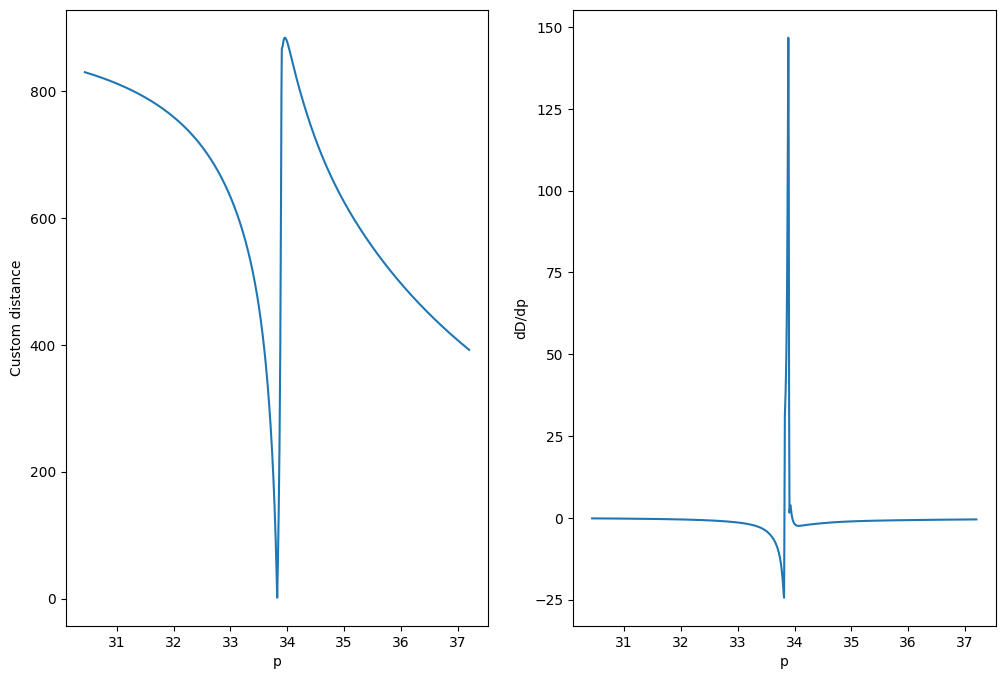

In [118]:
#The only thing we need to change is where the parameter is in param space! And distance function if we want!

def plots_sensitivity():
    datapoints = 1000 # How many steps in parameter space we have taken
    p_seq = np.linspace(30.44, 37.2, datapoints) #Change depending on parameter, 10%
    D_p = []
    p_collect = []
    for i in range(np.size(p_seq)):
        ########################################
        p_params = np.array([
                    246.96291990024542, 246.96291990024542, 246.96291990024542,
                    24.78485282457379, 24.78485282457379, 24.78485282457379,
                    0.024884149937163258, 0.024884149937163258, 0.024884149937163258,
                    5, 5, 5,
                    p_seq[i], 33.82307682700831, 33.82307682700831,
                    1.143402097500176, 1.143402097500176, 1.143402097500176,
                    0.7833664565550977, 0.7833664565550977, 0.7833664565550977
                    ]) #Need to change this! In this case k1
        ########################################
        p_collect.append(p_params)
        data_p = solve_ode(p_params, t)
        dist = combined_distance(true_data, data_p) #Can also change the distance function
        D_p.append(dist)

    step_size = np.array([100,500,1000]) #Steps to take right and left, the higher 
                                        #the number, the closer to the true value, here 1%, 0.1%, 0.02% of true value

    #To get indices we sample:
    indices_array = []
    for i in step_size:
        indices_array.append(np.array([datapoints//i, -datapoints//i])) #How many steps do we record?

    #To get the ks that correspond to the indices we sample, and create useful arrays:
    global min_ind
    min_ind = int(min_val_ind(D_p))
    global lowestD_p
    lowestD_p = p_seq[min_ind]
    global lowestD
    lowestD = D_p[min_ind]
    p_array = np.array([p_seq, D_p])
    grad = np.gradient(p_array) #Could also do np.diff, same result
    dDdp = grad[1][1]
    array_p_eval = []
    array_D_eval = []
    dD_array = []
    for i in indices_array:
        upperp = min_ind + i[0]
        lowerp = min_ind - i[0]
        array_p_eval.append(np.array([p_seq[int(upperp)], p_seq[int(lowerp)]])) #Save parameters
        array_D_eval.append(np.array([D_p[int(upperp)], D_p[int(lowerp)]])) #Same for distance
        dD_array.append(np.array([dDdp[int(upperp)], dDdp[int(lowerp)]])) #Same for derivative

    
    fig, axs = plt.subplots(1, 2, figsize=(12, 8))
    axs = axs.flatten()
    axs[0].plot(p_seq, D_p)
    axs[0].set_ylabel("Custom distance")
    axs[0].set_xlabel("p")
    axs[1].plot(p_seq, dDdp)
    axs[1].set_ylabel("dD/dp")
    axs[1].set_xlabel("p")

    return min_ind, p_seq, D_p, dDdp, array_p_eval, array_D_eval #It returns where it is being evaluated!

def calc_sens_metric(array_p_eval, array_D_eval):
    p_raw = []
    D_raw = []
    for i in array_p_eval:  # Get raw arrays for metric calculation
        p_raw.append(i[0])
        p_raw.append(i[1])
    for i in array_D_eval:  # Get raw arrays for metric calculation
        D_raw.append(i[0])
        D_raw.append(i[1])
    deltaD = []
    deltap = []
    for p in p_raw:
        deltap.append(np.abs(p) - np.abs(lowestD_p))
    for D in D_raw:
        deltaD.append(np.abs(D) - np.abs(lowestD))
    metric = []
    for i in range(len(deltaD)):
        metric.append(np.abs(deltaD[i]) / np.abs(deltap[i]))
    result_sense = np.log(np.mean(metric))
    return result_sense

b_min, b_seq, D_b, dDdb, array_p_eval_b, array_D_eval_b = plots_sensitivity()

In [119]:
b_metric = calc_sens_metric(array_p_eval_b, array_D_eval_b)

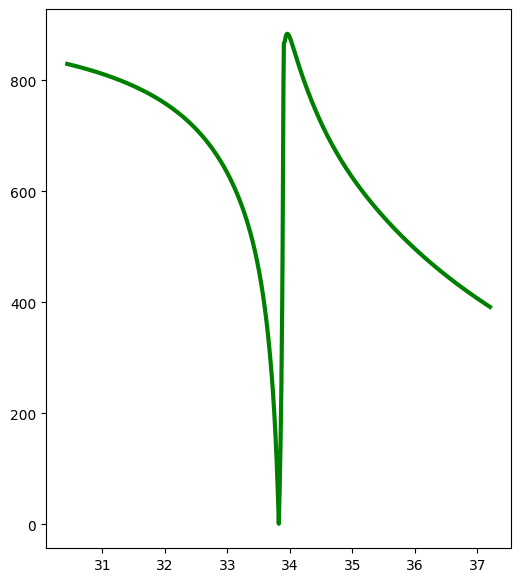

In [120]:
fig, ax = plt.subplots(figsize=(6,7))
ax.plot(b_seq, D_b, color = "green", label = "b", linewidth = 3) 

# Now try with dm1

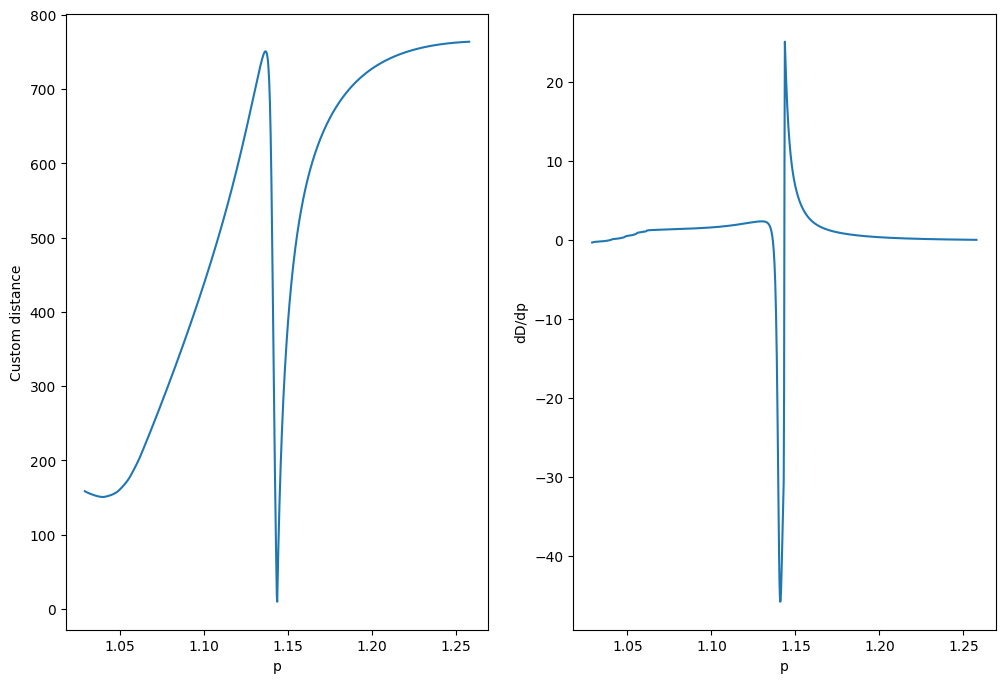

In [121]:
#The only thing we need to change is where the parameter is in param space! And distance function if we want!

def plots_sensitivity():
    datapoints = 1000 # How many steps in parameter space we have taken
    p_seq = np.linspace(1.029, 1.25774, datapoints) #Change depending on parameter, 10%
    D_p = []
    p_collect = []
    for i in range(np.size(p_seq)):
        ########################################
        p_params = np.array([
                    246.96291990024542, 246.96291990024542, 246.96291990024542,
                    24.78485282457379, 24.78485282457379, 24.78485282457379,
                    0.024884149937163258, 0.024884149937163258, 0.024884149937163258,
                    5, 5, 5,
                    33.82307682700831, 33.82307682700831, 33.82307682700831,
                    p_seq[i], 1.143402097500176, 1.143402097500176,
                    0.7833664565550977, 0.7833664565550977, 0.7833664565550977
                    ]) #Need to change this! In this case k1
        ########################################
        p_collect.append(p_params)
        data_p = solve_ode(p_params, t)
        dist = combined_distance(true_data, data_p) #Can also change the distance function
        D_p.append(dist)

    step_size = np.array([100,500,1000]) #Steps to take right and left, the higher 
                                        #the number, the closer to the true value, here 1%, 0.1%, 0.02% of true value

    #To get indices we sample:
    indices_array = []
    for i in step_size:
        indices_array.append(np.array([datapoints//i, -datapoints//i])) #How many steps do we record?

    #To get the ks that correspond to the indices we sample, and create useful arrays:
    global min_ind
    min_ind = int(min_val_ind(D_p))
    global lowestD_p
    lowestD_p = p_seq[min_ind]
    global lowestD
    lowestD = D_p[min_ind]
    p_array = np.array([p_seq, D_p])
    grad = np.gradient(p_array) #Could also do np.diff, same result
    dDdp = grad[1][1]
    array_p_eval = []
    array_D_eval = []
    dD_array = []
    for i in indices_array:
        upperp = min_ind + i[0]
        lowerp = min_ind - i[0]
        array_p_eval.append(np.array([p_seq[int(upperp)], p_seq[int(lowerp)]])) #Save parameters
        array_D_eval.append(np.array([D_p[int(upperp)], D_p[int(lowerp)]])) #Same for distance
        dD_array.append(np.array([dDdp[int(upperp)], dDdp[int(lowerp)]])) #Same for derivative

    
    fig, axs = plt.subplots(1, 2, figsize=(12, 8))
    axs = axs.flatten()
    axs[0].plot(p_seq, D_p)
    axs[0].set_ylabel("Custom distance")
    axs[0].set_xlabel("p")
    axs[1].plot(p_seq, dDdp)
    axs[1].set_ylabel("dD/dp")
    axs[1].set_xlabel("p")

    return min_ind, p_seq, D_p, dDdp, array_p_eval, array_D_eval #It returns where it is being evaluated!

def calc_sens_metric(array_p_eval, array_D_eval):
    p_raw = []
    D_raw = []
    for i in array_p_eval:  # Get raw arrays for metric calculation
        p_raw.append(i[0])
        p_raw.append(i[1])
    for i in array_D_eval:  # Get raw arrays for metric calculation
        D_raw.append(i[0])
        D_raw.append(i[1])
    deltaD = []
    deltap = []
    for p in p_raw:
        deltap.append(np.abs(p) - np.abs(lowestD_p))
    for D in D_raw:
        deltaD.append(np.abs(D) - np.abs(lowestD))
    metric = []
    for i in range(len(deltaD)):
        metric.append(np.abs(deltaD[i]) / np.abs(deltap[i]))
    result_sense = np.log(np.mean(metric))
    return result_sense

dm_min, dm_seq, D_dm, dDddm, array_p_eval_dm, array_D_eval_dm = plots_sensitivity()

In [122]:
dm_metric = calc_sens_metric(array_p_eval_dm, array_D_eval_dm)

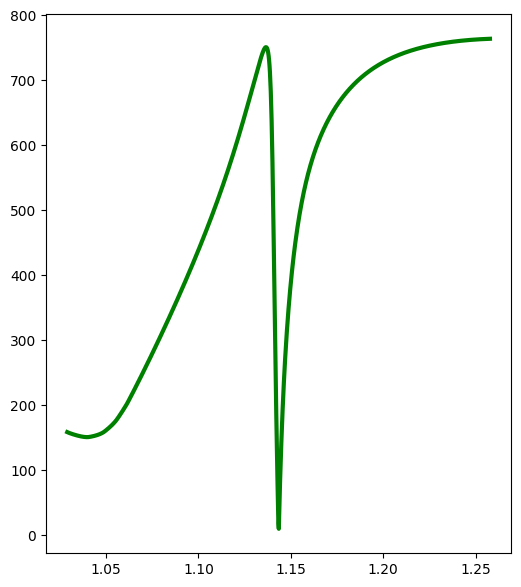

In [123]:
fig, ax = plt.subplots(figsize=(6,7))
ax.plot(dm_seq, D_dm, color = "green", label = "b", linewidth = 3) 

# Now try with dp1

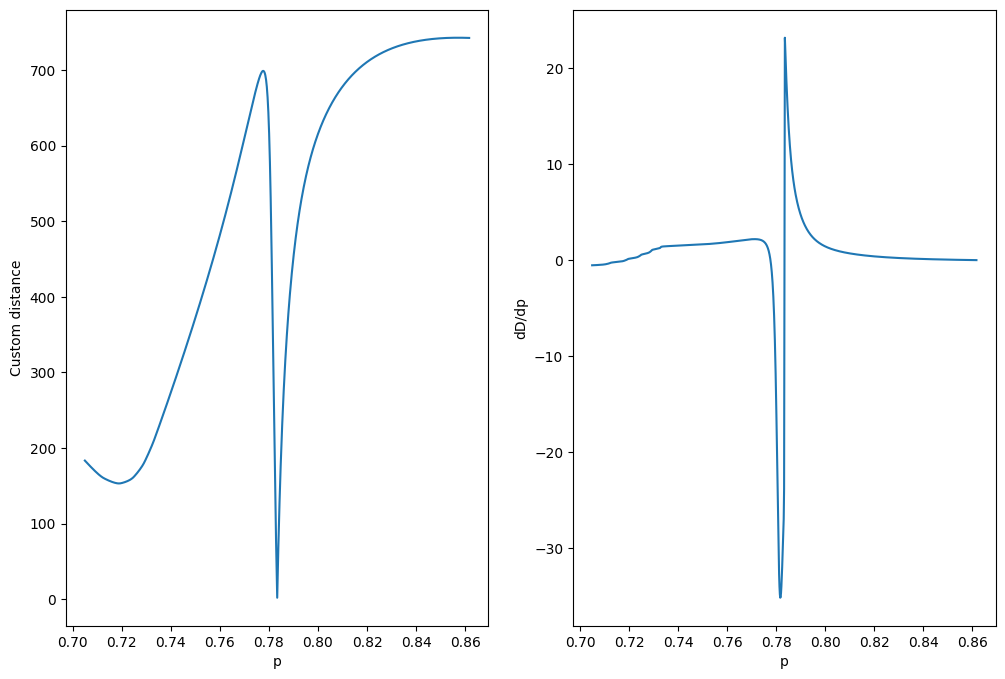

In [124]:
#The only thing we need to change is where the parameter is in param space! And distance function if we want!

def plots_sensitivity():
    datapoints = 1000 # How many steps in parameter space we have taken
    p_seq = np.linspace(0.70497, 0.86163, datapoints) #Change depending on parameter, 10%
    D_p = []
    p_collect = []
    for i in range(np.size(p_seq)):
        ########################################
        p_params = np.array([
                    246.96291990024542, 246.96291990024542, 246.96291990024542,
                    24.78485282457379, 24.78485282457379, 24.78485282457379,
                    0.024884149937163258, 0.024884149937163258, 0.024884149937163258,
                    5, 5, 5,
                    33.82307682700831, 33.82307682700831, 33.82307682700831,
                    1.143402097500176, 1.143402097500176, 1.143402097500176,
                    p_seq[i], 0.7833664565550977, 0.7833664565550977
                    ]) #Need to change this! In this case k1
        ########################################
        p_collect.append(p_params)
        data_p = solve_ode(p_params, t)
        dist = combined_distance(true_data, data_p) #Can also change the distance function
        D_p.append(dist)

    step_size = np.array([100,500,1000]) #Steps to take right and left, the higher 
                                        #the number, the closer to the true value, here 1%, 0.1%, 0.02% of true value

    #To get indices we sample:
    indices_array = []
    for i in step_size:
        indices_array.append(np.array([datapoints//i, -datapoints//i])) #How many steps do we record?

    #To get the ks that correspond to the indices we sample, and create useful arrays:
    global min_ind
    min_ind = int(min_val_ind(D_p))
    global lowestD_p
    lowestD_p = p_seq[min_ind]
    global lowestD
    lowestD = D_p[min_ind]
    p_array = np.array([p_seq, D_p])
    grad = np.gradient(p_array) #Could also do np.diff, same result
    dDdp = grad[1][1]
    array_p_eval = []
    array_D_eval = []
    dD_array = []
    for i in indices_array:
        upperp = min_ind + i[0]
        lowerp = min_ind - i[0]
        array_p_eval.append(np.array([p_seq[int(upperp)], p_seq[int(lowerp)]])) #Save parameters
        array_D_eval.append(np.array([D_p[int(upperp)], D_p[int(lowerp)]])) #Same for distance
        dD_array.append(np.array([dDdp[int(upperp)], dDdp[int(lowerp)]])) #Same for derivative

    
    fig, axs = plt.subplots(1, 2, figsize=(12, 8))
    axs = axs.flatten()
    axs[0].plot(p_seq, D_p)
    axs[0].set_ylabel("Custom distance")
    axs[0].set_xlabel("p")
    axs[1].plot(p_seq, dDdp)
    axs[1].set_ylabel("dD/dp")
    axs[1].set_xlabel("p")

    return min_ind, p_seq, D_p, dDdp, array_p_eval, array_D_eval #It returns where it is being evaluated!

def calc_sens_metric(array_p_eval, array_D_eval):
    p_raw = []
    D_raw = []
    for i in array_p_eval:  # Get raw arrays for metric calculation
        p_raw.append(i[0])
        p_raw.append(i[1])
    for i in array_D_eval:  # Get raw arrays for metric calculation
        D_raw.append(i[0])
        D_raw.append(i[1])
    deltaD = []
    deltap = []
    for p in p_raw:
        deltap.append(np.abs(p) - np.abs(lowestD_p))
    for D in D_raw:
        deltaD.append(np.abs(D) - np.abs(lowestD))
    metric = []
    for i in range(len(deltaD)):
        metric.append(np.abs(deltaD[i]) / np.abs(deltap[i]))
    result_sense = np.log(np.mean(metric))
    return result_sense

dp_min, dp_seq, D_dp, dDddp, array_p_eval_dp, array_D_eval_dp = plots_sensitivity()

In [125]:
dp_metric = calc_sens_metric(array_p_eval_dp, array_D_eval_dp)

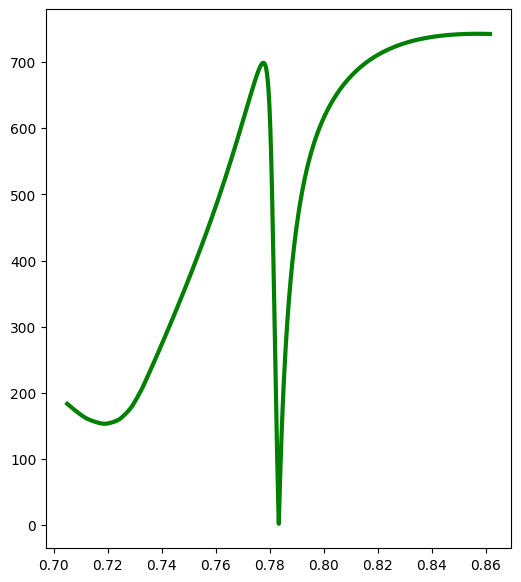

In [126]:
fig, ax = plt.subplots(figsize=(6,7))
ax.plot(dp_seq, D_dp, color = "green", label = "dp", linewidth = 3) 

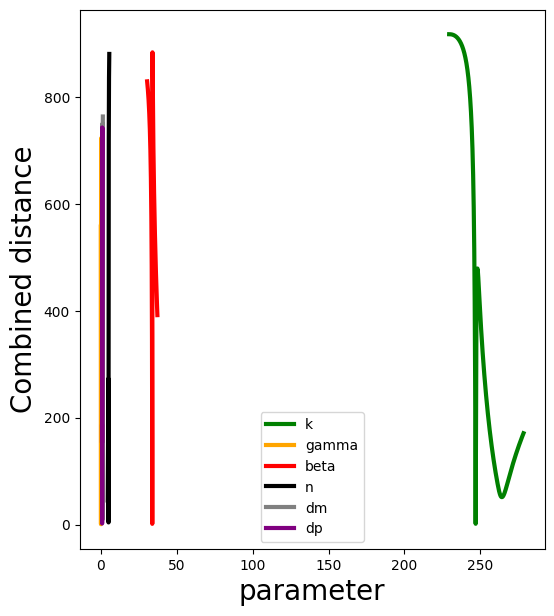

In [127]:
fig, ax = plt.subplots(figsize=(6,7))
ax.plot(k_seq, D_k, color = "green", label = "k", linewidth = 3) 
ax.plot(g_seq, D_g, color = "orange", label = "gamma", linewidth = 3) 
ax.plot(b_seq, D_b, color = "red", label = "beta", linewidth = 3) 
ax.plot(n_seq, D_n, color = "black", label = "n", linewidth = 3) 
ax.plot(dm_seq, D_dm, color = "gray", label = "dm", linewidth = 3) 
ax.plot(dp_seq, D_dp, color = "purple", label = "dp", linewidth = 3) 
ax.set_xlabel('parameter', fontsize = 20) 
ax.set_ylabel('Combined distance', fontsize = 20) 
plt.legend()
plt.show()

In [135]:
k_seqp = k_seq
D_kp = D_k
g_seqp =g_seq
D_gp =D_g
b_seqp =b_seq
D_bp =D_b
n_seqp =n_seq
D_np =D_n
dm_seqp =dm_seq
D_dmp =D_dm
dp_seqp =dp_seq
D_dpp =D_dp
a_seqp= a_seq
D_ap =D_a

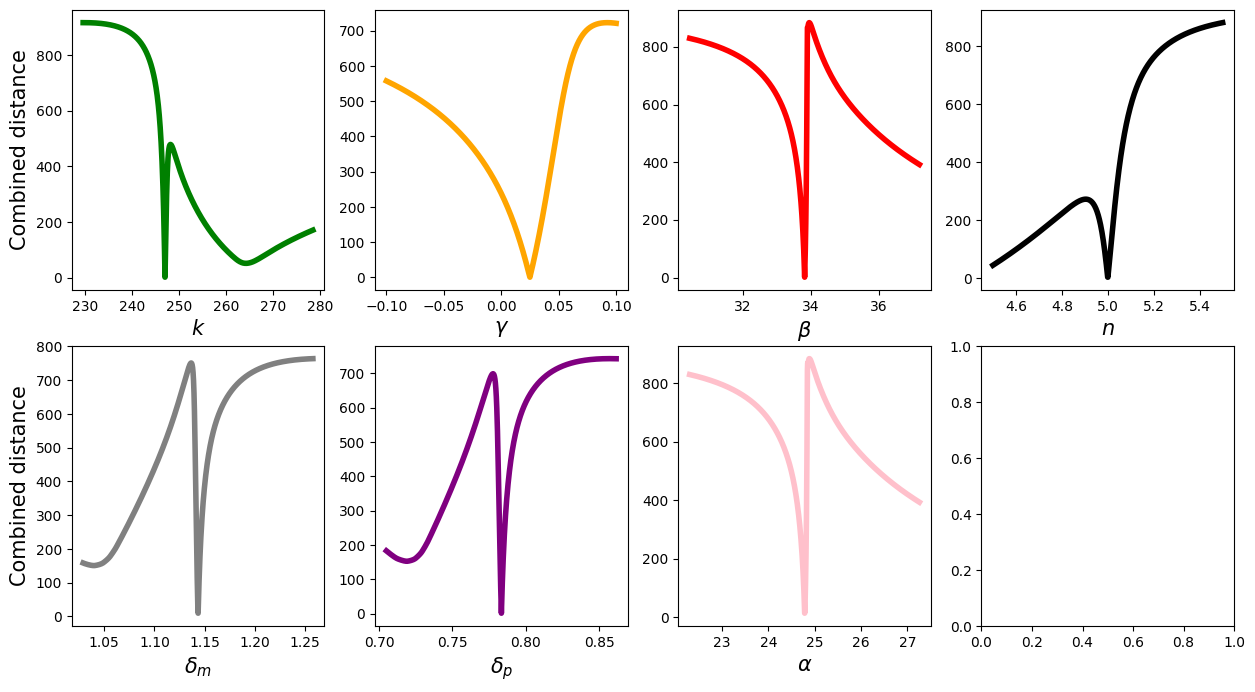

In [136]:
fig, axs = plt.subplots(2, 4, figsize=(15,8))
axs = axs.flatten()

variable_labels = [r"$k$", r"$\gamma$", r"$\beta$", r"$n$", r"$\delta_m$", r"$\delta_p$", r"$\alpha$"]
axs[0].plot(k_seqp, D_kp, color = "green", label = r"$k$", linewidth = 4) 
axs[1].plot(g_seqp, D_gp, color = "orange", label = r"$\gamma$", linewidth = 4) 
axs[2].plot(b_seqp, D_bp, color = "red", label = r"$\beta$", linewidth = 4) 
axs[3].plot(n_seqp, D_np, color = "black", label = r"$n$", linewidth = 4) 
axs[4].plot(dm_seqp, D_dm, color = "gray", label = r"$\delta_m$", linewidth = 4) 
axs[5].plot(dp_seqp, D_dpp, color = "purple", label = r"$\delta_p$", linewidth = 4) 
axs[6].plot(a_seqp, D_ap, color = "pink", label = r"$\alpha$", linewidth = 4) 
for i in range(7):
    axs[i].set_xlabel(variable_labels[i], fontsize = 15)
axs[0].set_ylabel("Combined distance", fontsize = 15)
axs[4].set_ylabel("Combined distance", fontsize = 15)

plt.show()

# Create pretty plot...

In [137]:
mink = k_seq[min_k]
ming = g_seq[min_g]
minb = b_seq[b_min]
minn = n_seq[min_n]
mindm = dm_seq[dm_min]
mindp = dp_seq[dp_min]
mina = a_seq[min_a]

minp = [mink, ming, minb, minn, mindm, mindp]

In [138]:
min_k_list = [mink] * len(k_seq)
min_g_list = [ming] * len(g_seq)
min_b_list = [minb] * len(b_seq)
min_n_list = [minn] * len(n_seq)
min_dm_list = [mindm] * len(dm_seq)
min_dp_list = [mindp] * len(dp_seq)
min_a_list = [mina] * len(a_seq)

In [139]:
norm_k = [x - y for x, y in zip(k_seq, min_k_list)]
norm_g = [x - y for x, y in zip(g_seq, min_g_list)]
norm_b = [x - y for x, y in zip(b_seq, min_b_list)]
norm_n = [x - y for x, y in zip(n_seq, min_n_list)]
norm_dm = [x - y for x, y in zip(dm_seq, min_dm_list)]
norm_dp = [x - y for x, y in zip(dp_seq, min_dp_list)]
norm_a = [x - y for x, y in zip(a_seq, min_a_list)]

In [140]:
def normalise(p_seq, min_p):
    minp = p_seq[min_p]
    min_p_list = [minp] * len(p_seq)
    norm_p = [x - y for x, y in zip(p_seq, min_p_list)]
    return norm_p


In [141]:
#fig, axs = plt.subplots(3, 2, figsize=(8, 12))
#axs = axs.flatten()

#variable_labels = ["k", "gamma", "beta", "n", "dm", "dp"]
#axs[0].plot(norm_k, D_k, color = "green", label = "k", linewidth = 3) 
#axs[1].plot(norm_g, D_g, color = "orange", label = "gamma", linewidth = 3) 
#axs[2].plot(norm_b, D_b, color = "red", label = "beta", linewidth = 3) 
#axs[3].plot(norm_n, D_n, color = "black", label = "n", linewidth = 3) 
#axs[4].plot(norm_dm, D_dm, color = "gray", label = "dm", linewidth = 3) 
#axs[5].plot(norm_dp, D_dp, color = "purple", label = "dp", linewidth = 3) 
#for i in range(6):
    #axs[i].set_xlabel(variable_labels[i])
    #axs[i].set_ylabel(r"Combined distance")

#plt.show()

wider range for gamma

In [142]:
true_values = [246.96291990024542, 
                   24.78485282457379,
                   0.024884149937163258,
                   5,
                   33.82307682700831,
                   1.143402097500176,
                   0.7833664565550977]

# Now for an actually accurate metric... new sensitivity plots and arrays...

In [143]:
def plots_sensitivity_narrow_g(true_value):
    offset = 0.01
    datapoints = 1000 # How many steps in parameter space we have taken
    p_seq = np.linspace(true_value + offset, true_value - offset, datapoints) #Change depending on parameter, 10%
    D_p = []
    p_collect = []
    for i in range(np.size(p_seq)):
        ########################################
        p_params = np.array([
                    246.96291990024542, 246.96291990024542, 246.96291990024542,
                    24.78485282457379, 24.78485282457379, 24.78485282457379,
                    p_seq[i], 0.024884149937163258, 0.024884149937163258,
                    5, 5, 5,
                    33.82307682700831, 33.82307682700831, 33.82307682700831,
                    1.143402097500176, 1.143402097500176, 1.143402097500176,
                    0.7833664565550977, 0.7833664565550977, 0.7833664565550977
                    ]) #Need to change this! In this case k1
        ########################################
        p_collect.append(p_params)
        data_p = solve_ode(p_params, t)
        dist = combined_distance(true_data, data_p) #Can also change the distance function
        D_p.append(dist)

    step_size = np.array([2,4,10,100,500]) #Steps to take right and left, the higher 

    #To get indices we sample:
    indices_array = []
    for i in step_size:
        indices_array.append(np.array([datapoints//i])) #How many steps do we record?

    #To get the ks that correspond to the indices we sample, and create useful arrays:
    global min_ind
    min_ind = int(min_val_ind(D_p))
    global lowestD_p
    lowestD_p = p_seq[min_ind]
    global lowestD
    lowestD = D_p[min_ind]
    p_array = np.array([p_seq, D_p])
    grad = np.gradient(p_array) #Could also do np.diff, same result
    dDdp = grad[1][1]
    array_p_eval = []
    array_D_eval = []
    dD_array = []
    for i in indices_array:
        upperp = min_ind + (i[0]-1)
        lowerp = min_ind - (i[0]-1)
        array_p_eval.append(np.array([p_seq[int(upperp)], p_seq[int(lowerp)]])) #Save parameters
        array_D_eval.append(np.array([D_p[int(upperp)], D_p[int(lowerp)]])) #Same for distance
        dD_array.append(np.array([dDdp[int(upperp)], dDdp[int(lowerp)]])) #Same for derivative
    norm_p = normalise(p_seq, min_ind)

    return norm_p, min_ind, p_seq, D_p, dDdp, array_p_eval, array_D_eval

norm_g, min_g, g_seq, D_g, dDdg, array_p_eval_g, array_D_eval_g = plots_sensitivity_narrow_g(0.024884149937163258)

In [144]:
g_metric = calc_sens_metric(array_p_eval_g, array_D_eval_g)

# now k

In [145]:
def plots_sensitivity_narrow_k(true_value):
    offset = 0.01
    datapoints = 1000 # How many steps in parameter space we have taken
    p_seq = np.linspace(true_value + offset, true_value - offset, datapoints) #Change depending on parameter, 10%
    D_p = []
    p_collect = []
    for i in range(np.size(p_seq)):
        ########################################
        p_params = np.array([
                    p_seq[i], 246.96291990024542, 246.96291990024542,
                    24.78485282457379, 24.78485282457379, 24.78485282457379,
                    0.024884149937163258, 0.024884149937163258, 0.024884149937163258,
                    5, 5, 5,
                    33.82307682700831, 33.82307682700831, 33.82307682700831,
                    1.143402097500176, 1.143402097500176, 1.143402097500176,
                    0.7833664565550977, 0.7833664565550977, 0.7833664565550977
                    ]) #Need to change this! In this case k1
        ########################################
        p_collect.append(p_params)
        data_p = solve_ode(p_params, t)
        dist = combined_distance(true_data, data_p) #Can also change the distance function
        D_p.append(dist)

    step_size = np.array([2,4,10,100,500]) #Steps to take right and left, the higher 

    #To get indices we sample:
    indices_array = []
    for i in step_size:
        indices_array.append(np.array([datapoints//i])) #How many steps do we record?

    #To get the ks that correspond to the indices we sample, and create useful arrays:
    global min_ind
    min_ind = int(min_val_ind(D_p))
    global lowestD_p
    lowestD_p = p_seq[min_ind]
    global lowestD
    lowestD = D_p[min_ind]
    p_array = np.array([p_seq, D_p])
    grad = np.gradient(p_array) #Could also do np.diff, same result
    dDdp = grad[1][1]
    array_p_eval = []
    array_D_eval = []
    dD_array = []
    for i in indices_array:
        upperp = min_ind + (i[0]-1)
        lowerp = min_ind - (i[0]-1)
        array_p_eval.append(np.array([p_seq[int(upperp)], p_seq[int(lowerp)]])) #Save parameters
        array_D_eval.append(np.array([D_p[int(upperp)], D_p[int(lowerp)]])) #Same for distance
        dD_array.append(np.array([dDdp[int(upperp)], dDdp[int(lowerp)]])) #Same for derivative
    norm_p = normalise(p_seq, min_ind)

    return norm_p, min_ind, p_seq, D_p, dDdp, array_p_eval, array_D_eval

norm_k, min_k, k_seq, D_k, dDdk, array_p_eval_k, array_D_eval_k = plots_sensitivity_narrow_k(246.96291990024542)

k_metric = calc_sens_metric(array_p_eval_k, array_D_eval_k)


# now b

In [146]:
def plots_sensitivity_narrow_a(true_value):
    offset = 0.01
    datapoints = 1000 # How many steps in parameter space we have taken
    p_seq = np.linspace(true_value + offset, true_value - offset, datapoints) #Change depending on parameter, 10%
    D_p = []
    p_collect = []
    for i in range(np.size(p_seq)):
        ########################################
        p_params = np.array([
                    246.96291990024542, 246.96291990024542, 246.96291990024542,
                    p_seq[i], 24.78485282457379, 24.78485282457379,
                    0.024884149937163258, 0.024884149937163258, 0.024884149937163258,
                    5, 5, 5,
                    33.82307682700831, 33.82307682700831, 33.82307682700831,
                    1.143402097500176, 1.143402097500176, 1.143402097500176,
                    0.7833664565550977, 0.7833664565550977, 0.7833664565550977
                    ]) #Need to change this! In this case k1
        ########################################
        p_collect.append(p_params)
        data_p = solve_ode(p_params, t)
        dist = combined_distance(true_data, data_p) #Can also change the distance function
        D_p.append(dist)

    step_size = np.array([2,4,10,100,500]) #Steps to take right and left, the higher 

    #To get indices we sample:
    indices_array = []
    for i in step_size:
        indices_array.append(np.array([datapoints//i])) #How many steps do we record?

    #To get the ks that correspond to the indices we sample, and create useful arrays:
    global min_ind
    min_ind = int(min_val_ind(D_p))
    global lowestD_p
    lowestD_p = p_seq[min_ind]
    global lowestD
    lowestD = D_p[min_ind]
    p_array = np.array([p_seq, D_p])
    grad = np.gradient(p_array) #Could also do np.diff, same result
    dDdp = grad[1][1]
    array_p_eval = []
    array_D_eval = []
    dD_array = []
    for i in indices_array:
        upperp = min_ind + (i[0]-1)
        lowerp = min_ind - (i[0]-1)
        array_p_eval.append(np.array([p_seq[int(upperp)], p_seq[int(lowerp)]])) #Save parameters
        array_D_eval.append(np.array([D_p[int(upperp)], D_p[int(lowerp)]])) #Same for distance
        dD_array.append(np.array([dDdp[int(upperp)], dDdp[int(lowerp)]])) #Same for derivative
    norm_p = normalise(p_seq, min_ind)

    return norm_p, min_ind, p_seq, D_p, dDdp, array_p_eval, array_D_eval

norm_a, min_a, a_seq, D_a, dDda, array_p_eval_a, array_D_eval_a = plots_sensitivity_narrow_a(24.78485282457379)

a_metric = calc_sens_metric(array_p_eval_a, array_D_eval_a)


# now n

In [147]:
def plots_sensitivity_narrow_n(true_value):
    offset = 0.01
    datapoints = 1000 # How many steps in parameter space we have taken
    p_seq = np.linspace(true_value + offset, true_value - offset, datapoints) #Change depending on parameter, 10%
    D_p = []
    p_collect = []
    for i in range(np.size(p_seq)):
        ########################################
        p_params = np.array([
                    246.96291990024542, 246.96291990024542, 246.96291990024542,
                    24.78485282457379, 24.78485282457379, 24.78485282457379,
                    0.024884149937163258, 0.024884149937163258, 0.024884149937163258,
                    p_seq[i], 5, 5,
                    33.82307682700831, 33.82307682700831, 33.82307682700831,
                    1.143402097500176, 1.143402097500176, 1.143402097500176,
                    0.7833664565550977, 0.7833664565550977, 0.7833664565550977
                    ]) #Need to change this! In this case k1
        ########################################
        p_collect.append(p_params)
        data_p = solve_ode(p_params, t)
        dist = combined_distance(true_data, data_p) #Can also change the distance function
        D_p.append(dist)

    step_size = np.array([2,4,10,100,500]) #Steps to take right and left, the higher 

    #To get indices we sample:
    indices_array = []
    for i in step_size:
        indices_array.append(np.array([datapoints//i])) #How many steps do we record?

    #To get the ks that correspond to the indices we sample, and create useful arrays:
    global min_ind
    min_ind = int(min_val_ind(D_p))
    global lowestD_p
    lowestD_p = p_seq[min_ind]
    global lowestD
    lowestD = D_p[min_ind]
    p_array = np.array([p_seq, D_p])
    grad = np.gradient(p_array) #Could also do np.diff, same result
    dDdp = grad[1][1]
    array_p_eval = []
    array_D_eval = []
    dD_array = []
    for i in indices_array:
        upperp = min_ind + (i[0]-1)
        lowerp = min_ind - (i[0]-1)
        array_p_eval.append(np.array([p_seq[int(upperp)], p_seq[int(lowerp)]])) #Save parameters
        array_D_eval.append(np.array([D_p[int(upperp)], D_p[int(lowerp)]])) #Same for distance
        dD_array.append(np.array([dDdp[int(upperp)], dDdp[int(lowerp)]])) #Same for derivative
    norm_p = normalise(p_seq, min_ind)

    return norm_p, min_ind, p_seq, D_p, dDdp, array_p_eval, array_D_eval

norm_n, min_n, n_seq, D_n, dDdn, array_p_eval_n, array_D_eval_n = plots_sensitivity_narrow_n(5)

n_metric = calc_sens_metric(array_p_eval_n, array_D_eval_n)


# now dm

In [148]:
def plots_sensitivity_narrow_dm(true_value):
    offset = 0.01
    datapoints = 1000 # How many steps in parameter space we have taken
    p_seq = np.linspace(true_value + offset, true_value - offset, datapoints) #Change depending on parameter, 10%
    D_p = []
    p_collect = []
    for i in range(np.size(p_seq)):
        ########################################
        p_params = np.array([
                    246.96291990024542, 246.96291990024542, 246.96291990024542,
                    24.78485282457379, 24.78485282457379, 24.78485282457379,
                    0.024884149937163258, 0.024884149937163258, 0.024884149937163258,
                    5, 5, 5,
                    33.82307682700831, 33.82307682700831, 33.82307682700831,
                    p_seq[i], 1.143402097500176, 1.143402097500176,
                    0.7833664565550977, 0.7833664565550977, 0.7833664565550977
                    ]) #Need to change this! In this case k1
        ########################################
        p_collect.append(p_params)
        data_p = solve_ode(p_params, t)
        dist = combined_distance(true_data, data_p) #Can also change the distance function
        D_p.append(dist)

    step_size = np.array([2,4,10,100,500]) #Steps to take right and left, the higher 

    #To get indices we sample:
    indices_array = []
    for i in step_size:
        indices_array.append(np.array([datapoints//i])) #How many steps do we record?

    #To get the ks that correspond to the indices we sample, and create useful arrays:
    global min_ind
    min_ind = int(min_val_ind(D_p))
    global lowestD_p
    lowestD_p = p_seq[min_ind]
    global lowestD
    lowestD = D_p[min_ind]
    p_array = np.array([p_seq, D_p])
    grad = np.gradient(p_array) #Could also do np.diff, same result
    dDdp = grad[1][1]
    array_p_eval = []
    array_D_eval = []
    dD_array = []
    for i in indices_array:
        upperp = min_ind + (i[0]-1)
        lowerp = min_ind - (i[0]-1)
        array_p_eval.append(np.array([p_seq[int(upperp)], p_seq[int(lowerp)]])) #Save parameters
        array_D_eval.append(np.array([D_p[int(upperp)], D_p[int(lowerp)]])) #Same for distance
        dD_array.append(np.array([dDdp[int(upperp)], dDdp[int(lowerp)]])) #Same for derivative
    norm_p = normalise(p_seq, min_ind)

    return norm_p, min_ind, p_seq, D_p, dDdp, array_p_eval, array_D_eval

norm_dm, min_dm, dm_seq, D_dm, dDddm, array_p_eval_dm, array_D_eval_dm = plots_sensitivity_narrow_dm(1.143402097500176)

dm_metric = calc_sens_metric(array_p_eval_dm, array_D_eval_dm)

# now dp

In [149]:
def plots_sensitivity_narrow_dp(true_value):
    offset = 0.01
    datapoints = 1000 # How many steps in parameter space we have taken
    p_seq = np.linspace(true_value + offset, true_value - offset, datapoints) #Change depending on parameter, 10%
    D_p = []
    p_collect = []
    for i in range(np.size(p_seq)):
        ########################################
        p_params = np.array([
                    246.96291990024542, 246.96291990024542, 246.96291990024542,
                    24.78485282457379, 24.78485282457379, 24.78485282457379,
                    0.024884149937163258, 0.024884149937163258, 0.024884149937163258,
                    5, 5, 5,
                    33.82307682700831, 33.82307682700831, 33.82307682700831,
                    1.143402097500176, 1.143402097500176, 1.143402097500176,
                    p_seq[i], 0.7833664565550977, 0.7833664565550977
                    ]) #Need to change this! In this case k1
        ########################################
        p_collect.append(p_params)
        data_p = solve_ode(p_params, t)
        dist = combined_distance(true_data, data_p) #Can also change the distance function
        D_p.append(dist)

    step_size = np.array([2,4,10,100,500]) #Steps to take right and left, the higher 

    #To get indices we sample:
    indices_array = []
    for i in step_size:
        indices_array.append(np.array([datapoints//i])) #How many steps do we record?

    #To get the ks that correspond to the indices we sample, and create useful arrays:
    global min_ind
    min_ind = int(min_val_ind(D_p))
    global lowestD_p
    lowestD_p = p_seq[min_ind]
    global lowestD
    lowestD = D_p[min_ind]
    p_array = np.array([p_seq, D_p])
    grad = np.gradient(p_array) #Could also do np.diff, same result
    dDdp = grad[1][1]
    array_p_eval = []
    array_D_eval = []
    dD_array = []
    for i in indices_array:
        upperp = min_ind + (i[0]-1)
        lowerp = min_ind - (i[0]-1)
        array_p_eval.append(np.array([p_seq[int(upperp)], p_seq[int(lowerp)]])) #Save parameters
        array_D_eval.append(np.array([D_p[int(upperp)], D_p[int(lowerp)]])) #Same for distance
        dD_array.append(np.array([dDdp[int(upperp)], dDdp[int(lowerp)]])) #Same for derivative
    norm_p = normalise(p_seq, min_ind)

    return norm_p, min_ind, p_seq, D_p, dDdp, array_p_eval, array_D_eval

norm_dp, min_dp, dp_seq, D_dp, dDddp, array_p_eval_dp, array_D_eval_dp = plots_sensitivity_narrow_dp(0.7833664565550977)

dp_metric = calc_sens_metric(array_p_eval_dp, array_D_eval_dp)

# now b

In [150]:
def plots_sensitivity_narrow_b(true_value):
    offset = 0.01
    datapoints = 1000 # How many steps in parameter space we have taken
    p_seq = np.linspace(true_value + offset, true_value - offset, datapoints) #Change depending on parameter, 10%
    D_p = []
    p_collect = []
    for i in range(np.size(p_seq)):
        ########################################
        p_params = np.array([
                    246.96291990024542, 246.96291990024542, 246.96291990024542,
                    24.78485282457379, 24.78485282457379, 24.78485282457379,
                    0.024884149937163258, 0.024884149937163258, 0.024884149937163258,
                    5, 5, 5,
                    p_seq[i], 33.82307682700831, 33.82307682700831,
                    1.143402097500176, 1.143402097500176, 1.143402097500176,
                    0.7833664565550977, 0.7833664565550977, 0.7833664565550977
                    ]) #Need to change this! In this case k1
        ########################################
        p_collect.append(p_params)
        data_p = solve_ode(p_params, t)
        dist = combined_distance(true_data, data_p) #Can also change the distance function
        D_p.append(dist)

    step_size = np.array([2,4,10,100,500]) #Steps to take right and left, the higher 

    #To get indices we sample:
    indices_array = []
    for i in step_size:
        indices_array.append(np.array([datapoints//i])) #How many steps do we record?

    #To get the ks that correspond to the indices we sample, and create useful arrays:
    global min_ind
    min_ind = int(min_val_ind(D_p))
    global lowestD_p
    lowestD_p = p_seq[min_ind]
    global lowestD
    lowestD = D_p[min_ind]
    p_array = np.array([p_seq, D_p])
    grad = np.gradient(p_array) #Could also do np.diff, same result
    dDdp = grad[1][1]
    array_p_eval = []
    array_D_eval = []
    dD_array = []
    for i in indices_array:
        upperp = min_ind + (i[0]-1)
        lowerp = min_ind - (i[0]-1)
        array_p_eval.append(np.array([p_seq[int(upperp)], p_seq[int(lowerp)]])) #Save parameters
        array_D_eval.append(np.array([D_p[int(upperp)], D_p[int(lowerp)]])) #Same for distance
        dD_array.append(np.array([dDdp[int(upperp)], dDdp[int(lowerp)]])) #Same for derivative
    norm_p = normalise(p_seq, min_ind)

    return norm_p, min_ind, p_seq, D_p, dDdp, array_p_eval, array_D_eval

norm_b, min_b, b_seq, D_b, dDdb, array_p_eval_b, array_D_eval_b = plots_sensitivity_narrow_b(33.82307682700831)

b_metric = calc_sens_metric(array_p_eval_b, array_D_eval_b)

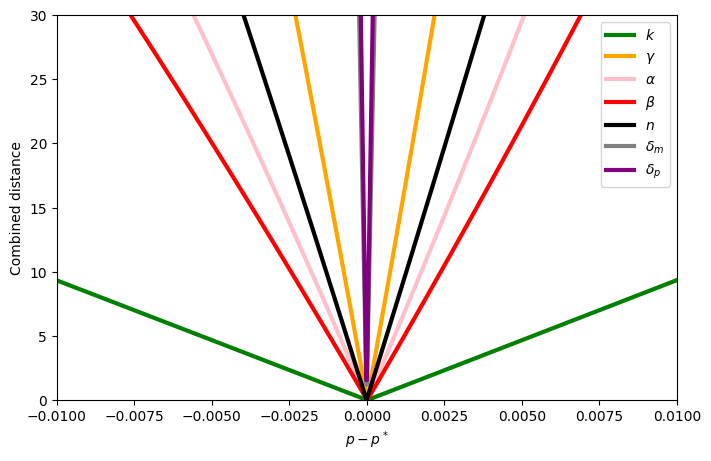

In [151]:
#pretty good plot...
fig, axs = plt.subplots(1,1, figsize=(8, 5))

axs.plot(norm_k, D_k, color = "green", label = r"$k$", linewidth = 3) 
axs.plot(norm_g, D_g, color = "orange", label = r"$\gamma$", linewidth = 3) 
axs.plot(norm_a, D_a, color = "pink", label = r"$\alpha$", linewidth = 3) 
axs.plot(norm_b, D_b, color = "red", label = r"$\beta$", linewidth = 3) 
axs.plot(norm_n, D_n, color = "black", label = r"$n$", linewidth = 3) 
axs.plot(norm_dm, D_dm, color = "gray", label = r"$\delta_m$", linewidth = 3) 
axs.plot(norm_dp, D_dp, color = "purple", label = r"$\delta_p$", linewidth = 3)
axs.set_xlim(-0.01, 0.01)
axs.set_xlabel(r"$p - p^*$", fontsize = 10)
axs.set_ylim(0, 30)
axs.set_ylabel(r"Combined distance", fontsize = 10)

plt.legend()
plt.show()


### Sensitivity takes +/-0.1 / 2,4,10,100,500 and takes average

In [152]:
print(k_metric, b_metric, a_metric, n_metric, g_metric, dm_metric, dp_metric)

6.720754225233644 8.2107350847543 8.520480684603593 8.83250105994961 9.384702251960476 11.435574831983882 11.60704393873036
